In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler 

from matplotlib import pyplot as plot

#biblioteca para fazer fazer a regressão
from sklearn.tree import DecisionTreeRegressor

#biblioteca para calcular uma métrica de avaliação
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_excel('https://github.com/andrevandor/ProjetoIntegrador/raw/master/data/HDI_1990_2019.xlsx')

## Treatment of Null Values

In [3]:
def EDA (df):
    eda_df = {}
    eda_df['Qtde_NaN'] = df.isnull().sum()
    eda_df['%_NaN'] = df.isnull().mean().round(2)
    eda_df['DType'] = df.dtypes
    eda_df['Qtde_Unicos'] = df.count()
    
    colunas = sorted(df.columns.tolist(), key=str.lower, reverse=False)
    eda_df['Qtde_Unicos'] = filtered_result = list(map(lambda x: len(df[x].unique().tolist()), colunas))
    
    eda_df['Media'] = df.mean().round(3)
    eda_df['Min'] = df.min()
    eda_df['Max'] = df.max()
    eda_df['STD'] = df.std().round(3)
    
    return pd.DataFrame(eda_df)

In [5]:
EDA(df.drop(['Ano','Paises','IDH','CPI (Corruption Index)'], axis = 1))

,Qtde_NaN,%_NaN,DType,Qtde_Unicos,Media,Min,Max,STD
Expectativa de vida no nascimento,84,0.01,float64,371,68.418,26.172,84.50000,9.530
Anos esperados de escolaridade,279,0.05,float64,5013,11.849,2.100,23.30000,3.358
Média de anos de escolaridade,551,0.10,float64,5,7.525,0.290,14.13215,3.180
Renda nacional bruta (RNB) per capita (PPP US$),446,0.08,float64,429,13408.952,14.000,131510.00000,16507.846
Faixa,1001,0.18,float64,2684,2.448,1.000,4.00000,1.109


In [6]:
#Analisando Expectativa de vida no nascimento
df_analise_nulls = df.copy()

indices = df_analise_nulls[df_analise_nulls['Expectativa de vida no nascimento'].isnull()].index
paises_com_linha_em_branco = []
for i in indices:
    if (df_analise_nulls.loc[i,'Paises'] not in paises_com_linha_em_branco):
        paises_com_linha_em_branco.append(df_analise_nulls.loc[i,'Paises'])

In [7]:
paises_com_linha_em_branco

['Korea (Republic of)', 'Cabo Verde', 'Eswatini (Kingdom of)']

In [8]:
df_analise_nulls.loc[df_analise_nulls['Paises']=='Korea (Republic of)'].head(2)

,Paises,Ano,Expectativa de vida no nascimento,Anos esperados de escolaridade,Média de anos de escolaridade,Renda nacional bruta (RNB) per capita (PPP US$),IDH,Faixa,CPI (Corruption Index)
22,Korea (Republic of),1990,NaN,NaN,NaN,8260.0,NaN,NaN,NaN
209,Korea (Republic of),1991,NaN,NaN,NaN,9330.0,NaN,NaN,NaN


In [9]:
df_analise_nulls.loc[df_analise_nulls['Paises']=='Cabo Verde'].head(2)

,Paises,Ano,Expectativa de vida no nascimento,Anos esperados de escolaridade,Média de anos de escolaridade,Renda nacional bruta (RNB) per capita (PPP US$),IDH,Faixa,CPI (Corruption Index)
124,Cabo Verde,1990,NaN,NaN,NaN,1140.0,NaN,NaN,NaN
311,Cabo Verde,1991,NaN,NaN,NaN,1160.0,NaN,NaN,NaN


In [10]:
df_analise_nulls.loc[df_analise_nulls['Paises']=='Eswatini (Kingdom of)'].head(2)

,Paises,Ano,Expectativa de vida no nascimento,Anos esperados de escolaridade,Média de anos de escolaridade,Renda nacional bruta (RNB) per capita (PPP US$),IDH,Faixa,CPI (Corruption Index)
137,Eswatini (Kingdom of),1990,NaN,NaN,NaN,3700.0,NaN,NaN,NaN
324,Eswatini (Kingdom of),1991,NaN,NaN,NaN,3820.0,NaN,NaN,NaN


In [11]:
#Os três países (Korea (Republic of), Cabo Verde, Eswatini (Kingdom of)) acima possuem dados somente em 2018, 
#por isso não possuem informações suficientes para uma Série Temporal. Serão removidos da base.
linhas_deletar = df_analise_nulls.loc[(df_analise_nulls['Paises']=='Korea (Republic of)')  | \
                                      (df_analise_nulls['Paises']=='Cabo Verde') | \
                                      (df_analise_nulls['Paises']=='Eswatini (Kingdom of)')].index.tolist()
df_analise_nulls.drop(index=linhas_deletar, inplace=True)

In [12]:
df_analise_nulls['Expectativa de vida no nascimento'].interpolate(method='linear', limit_direction='forward', inplace=True)
df_analise_nulls['Anos esperados de escolaridade'].interpolate(method='linear', limit_direction='forward', inplace=True)
df_analise_nulls['Média de anos de escolaridade'].interpolate(method='linear', limit_direction='forward', inplace=True)
df_analise_nulls['Renda nacional bruta (RNB) per capita (PPP US$)'].interpolate(method='linear', limit_direction='forward',\
                                                                                inplace=True)

In [13]:
df_analise_nulls.drop(['IDH','CPI (Corruption Index)'], axis=1, inplace=True)

In [14]:
EDA(df_analise_nulls.drop(['Ano','Paises'], axis=1))

,Qtde_NaN,%_NaN,DType,Qtde_Unicos,Media,Min,Max,STD
Expectativa de vida no nascimento,0,0.00,float64,456,68.415,26.172,84.50000,9.529
Anos esperados de escolaridade,0,0.00,float64,5009,11.773,2.100,23.30000,3.369
Média de anos de escolaridade,0,0.00,float64,5,7.323,0.290,14.13215,3.198
Renda nacional bruta (RNB) per capita (PPP US$),0,0.00,float64,615,13269.261,14.000,131510.00000,16501.264
Faixa,917,0.17,float64,2928,2.448,1.000,4.00000,1.109


In [15]:
df_1 = df_analise_nulls.copy()
df_1.reset_index(inplace=True)
df_1.drop('index', axis=1, inplace=True)

In [16]:
df_1['Indice_Vida'] = (df_1['Expectativa de vida no nascimento'] - 20)/(85 - 20)

indexer = df_1.index.to_list()
for i in indexer:
    if df_1.loc[i,'Anos esperados de escolaridade'] > 18:
        df_1.loc[i,'Indice_Escola'] = ((df_1.loc[i,'Média de anos de escolaridade'] / 15)\
                                       + (df_1.loc[i,'Anos esperados de escolaridade']/18)) / 2
    else:
        df_1.loc[i,'Indice_Escola'] = ((df_1.loc[i,'Média de anos de escolaridade'] / 15)\
                                       + (df_1.loc[i,'Anos esperados de escolaridade']/18)) / 2
        
df_1['Indice_Renda'] = (np.log(df_1['Renda nacional bruta (RNB) per capita (PPP US$)'])\
                        - np.log(100)) / (np.log(75000) - np.log(100))

In [17]:
df_1.loc[df_1.Indice_Renda < 0, 'Indice_Renda'] = 0
df_1.loc[df_1.Indice_Renda > 1, 'Indice_Renda'] = 0.99
df_1.loc[df_1.Indice_Escola > 1, 'Indice_Escola'] = 0.99

## Data Visualization

Correlações altas já esperadas, como Expectativa de Vida e Anos de Escolaridade 
e faixa de IDH e demais pilares, já que quando maior a faixa melhor o pilar 
porem temos um fato interessante que é o RNB correlacionado com os demais pilares. 



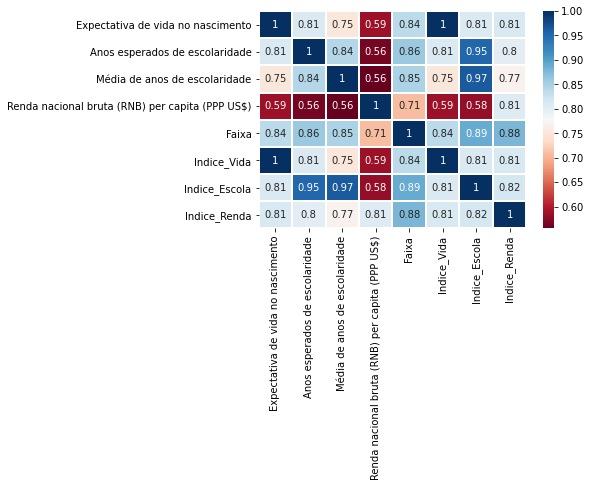

In [18]:
sns.heatmap(df_1.drop('Ano', axis=1).corr(), linewidths = 1, cmap = 'RdBu', annot = True)
print("Correlações altas já esperadas, como Expectativa de Vida e Anos de Escolaridade \n"\
      + "e faixa de IDH e demais pilares, já que quando maior a faixa melhor o pilar \n"
      + "porem temos um fato interessante que é o RNB correlacionado com os demais pilares. \n")

In [28]:
country_choices = [df_1[df_1.Faixa == 1].Paises.sample(1).to_list()[0],df_1[df_1.Faixa == 2].Paises.sample(1).to_list()[0],\
                  df_1[df_1.Faixa == 3].Paises.sample(1).to_list()[0],df_1[df_1.Faixa == 4].Paises.sample(1).to_list()[0]]

print('Paises escolhidos por faixa, aleatoriamente: \n\n'
      + 'Baixo desenvolvimento: ' + country_choices[0] + '\n'
      + 'Médio desenvolvimento: ' + country_choices[1] + '\n'
      + 'Alto desenvolvimento: ' + country_choices[2] + '\n'
      + 'Muito Alto desenvolvimento: ' + country_choices[3])

Paises escolhidos por faixa, aleatoriamente: 

Baixo desenvolvimento: Afghanistan
Médio desenvolvimento: Libya
Alto desenvolvimento: Kuwait
Muito Alto desenvolvimento: Russia


Baixo desenvolvimento



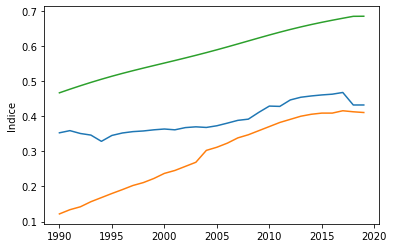

Médio desenvolvimento



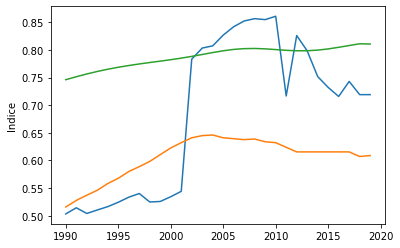

Alto desenvolvimento



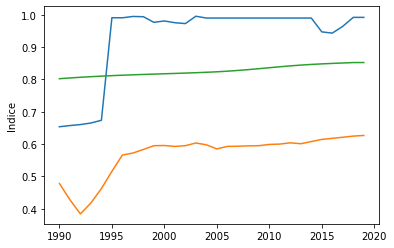

Muito Alto desenvolvimento



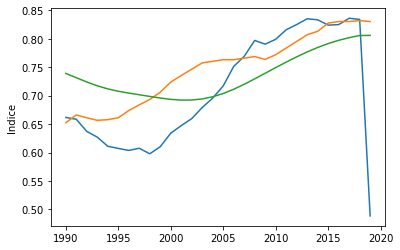


Dividimos um gráfico para cada faixa de HDI, percebemos que, infelizmente, os paises de baixo desenvolvimento 
tem um crescimento leve porem, comparado com os demais percebemos que a subida é menos acentuada, para a maioria das escolhas.
Paises em desenvolvimento muito alto tem seus indices muito proximos, uma subida acentuada e constante.


In [29]:
print('Baixo desenvolvimento\n')
sns.lineplot(y=df_1[df_1.Paises == country_choices[0]]['Indice_Renda'], x=df_1.Ano.unique(), data=df_1)
sns.lineplot(y=df_1[df_1.Paises == country_choices[0]]['Indice_Escola'], x=df_1.Ano.unique(), data=df_1)
sns.lineplot(y=df_1[df_1.Paises == country_choices[0]]['Indice_Vida'], x=df_1.Ano.unique(), data=df_1)
plot.ylabel('Indice')
plot.show()
print('Médio desenvolvimento\n')
sns.lineplot(y=df_1[df_1.Paises == country_choices[1]]['Indice_Renda'], x=df_1.Ano.unique(), data=df_1)
sns.lineplot(y=df_1[df_1.Paises == country_choices[1]]['Indice_Escola'], x=df_1.Ano.unique(), data=df_1)
sns.lineplot(y=df_1[df_1.Paises == country_choices[1]]['Indice_Vida'], x=df_1.Ano.unique(), data=df_1)
plot.ylabel('Indice')
plot.show()
print('Alto desenvolvimento\n')
sns.lineplot(y=df_1[df_1.Paises == country_choices[2]]['Indice_Renda'], x=df_1.Ano.unique(), data=df_1)
sns.lineplot(y=df_1[df_1.Paises == country_choices[2]]['Indice_Escola'], x=df_1.Ano.unique(), data=df_1)
sns.lineplot(y=df_1[df_1.Paises == country_choices[2]]['Indice_Vida'], x=df_1.Ano.unique(), data=df_1)
plot.ylabel('Indice')
plot.show()
print('Muito Alto desenvolvimento\n')
sns.lineplot(y=df_1[df_1.Paises == country_choices[3]]['Indice_Renda'], x=df_1.Ano.unique(), data=df_1)
sns.lineplot(y=df_1[df_1.Paises == country_choices[3]]['Indice_Escola'], x=df_1.Ano.unique(), data=df_1)
sns.lineplot(y=df_1[df_1.Paises == country_choices[3]]['Indice_Vida'], x=df_1.Ano.unique(), data=df_1)
plot.ylabel('Indice')
plot.show()

print('\nDividimos um gráfico para cada faixa de HDI, percebemos que, infelizmente, os paises de baixo desenvolvimento \n' \
     + 'tem um crescimento leve porem, comparado com os demais percebemos que a subida é menos acentuada, para a maioria das escolhas.\n' \
     + 'Paises em desenvolvimento muito alto tem seus indices muito proximos, uma subida acentuada e constante.')

In [30]:
sums = []
for i in range(1,5):
    sums.append(np.round(df_1[df_1.Faixa == i]['Renda nacional bruta (RNB) per capita (PPP US$)'].sum(),2))

In [31]:
df_sums = pd.DataFrame(sums)
df_sums.columns = ['Soma Faixas']

In [32]:
df_sums['% do Total'] = (df_sums['Soma Faixas']/df_sums['Soma Faixas'].sum())*100

In [33]:
df_sums.index = [1,2,3,4]

In [34]:
df_sums

,Soma Faixas,% do Total
1,2091234.42,3.242338
2,7633064.05,11.834623
3,17029501.32,26.403253
4,37743939.53,58.519787


In [35]:
print('Teriamos um melhor balanceamento entre as faixas de os paises na faixa 1 e 2 representassem um unica faixa.\n'\
     + 'De toda forma os paises da faixa 4 sozinhos detem o poder de compra das faixas 1,2 e 3, comparando com o correlação\n'\
     + 'onde podemos dizer que o pilar de PPP sustenta os demais eles tem muito mais chance de melhorarem ou manterem'\
     + 'seus indicadores.\n')

print(df_1[df_1.Ano == 2019].Faixa.value_counts())

print('\nPara tentar validar a hiposete da melhor divisão em 3 grupos iremos usar KNE e T-SNE')

Teriamos um melhor balanceamento entre as faixas de os paises na faixa 1 e 2 representassem um unica faixa.
De toda forma os paises da faixa 4 sozinhos detem o poder de compra das faixas 1,2 e 3, comparando com o correlação
onde podemos dizer que o pilar de PPP sustenta os demais eles tem muito mais chance de melhorarem ou manteremseus indicadores.

4.0    60
3.0    54
1.0    35
2.0    35
Name: Faixa, dtype: int64

Para tentar validar a hiposete da melhor divisão em 3 grupos iremos usar KNE e T-SNE


### K-means and t-SNE

In [36]:
df_grouped = df_1.drop(['Paises','Faixa','Indice_Vida','Indice_Escola','Indice_Renda'], axis=1).copy()

In [37]:
df_grouped = df_grouped[df_grouped.Ano == 2019]

In [38]:
df_grouped.drop('Ano', axis= 1, inplace = True)

In [39]:
df_grouped.head(2)

,Expectativa de vida no nascimento,Anos esperados de escolaridade,Média de anos de escolaridade,Renda nacional bruta (RNB) per capita (PPP US$)
5336,82.3,18.1,12.6,6859.0
5337,83.6,16.2,13.4,59375.0


In [40]:
scaler = StandardScaler()  
df_grouped_norm = scaler.fit_transform(df_grouped)

1 736.0
2 359.46
3 234.2
4 190.73
5 159.5
6 141.25
7 127.45
8 115.67
9 108.68
10 99.0
11 94.68
12 90.97
13 85.87
14 82.29
15 75.27
16 72.59
17 69.72
18 67.21
19 64.91
20 62.6


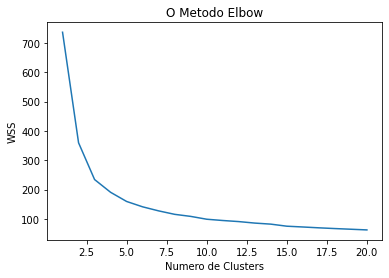

        0
0   48.84
1   65.15
2   81.44
3   83.63
4   88.56
5   90.23
6   90.76
7   93.96
8   91.10
9   95.63
10  96.09
11  94.40
12  95.83
13  91.46
14  96.44
15  96.06
16  96.39
17  96.57
18  96.45


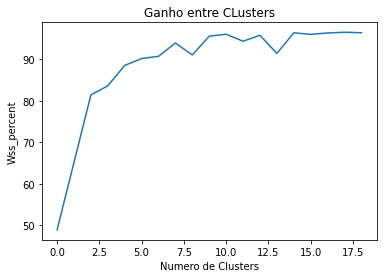

Como haviamos suspeitado e pelo que observamos nas informações de ganho para cada cluster processadonosso melhor momento de canho foi até o 3 clustes e depois começamos a ter um ganho leve e gradual.Portanto cruzando o WSS versus o WSS percent validamos 3 diviões de faixa.


In [41]:
X = np.array(df_grouped_norm)
wcss = []
wss_percent =  []

for i in range(1, 21):
    kmeans = KMeans(n_clusters = i, init = 'random')
    kmeans.fit(X)
    print(i,np.round(kmeans.inertia_,2))
    wcss.append(kmeans.inertia_)  
    if i > 1:
        wss_percent.append(np.round((kmeans.inertia_/wcss[i-2])*100,2))
    
plot.plot(range(1, 21), wcss)
plot.title('O Metodo Elbow')
plot.xlabel('Numero de Clusters')
plot.ylabel('WSS') #within cluster sum of squares
plot.show()

print(pd.DataFrame(wss_percent))

plot.plot(range(0, 19), wss_percent)
plot.title('Ganho entre CLusters')
plot.xlabel('Numero de Clusters')
plot.ylabel('Wss_percent')
plot.show()

print('Como haviamos suspeitado e pelo que observamos nas informações de ganho para cada cluster processado'\
    + 'nosso melhor momento de canho foi até o 3 clustes e depois começamos a ter um ganho leve e gradual.'\
    + 'Portanto cruzando o WSS versus o WSS percent validamos 3 diviões de faixa.')

In [42]:
n_clusters = 3
#Inicializando o KMeans
kmeans = KMeans(n_clusters)
#Fit nos dados
kmeans = kmeans.fit(X)
#predizendo os clusters
labels = kmeans.predict(X)
#Encontrando os centroides
C = kmeans.cluster_centers_

In [43]:
kmeans.cluster_centers_

array([[-1.11105158, -1.05305676, -1.17064557, -0.6036843 ],
       [ 0.33884918,  0.29875453,  0.41041088, -0.24406959],
       [ 1.08444053,  1.08417326,  1.00837778,  1.66579618]])

In [44]:
kmeans.labels_

array([1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2,
       1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [45]:
X_reduzido = TSNE(n_components=2).fit_transform(X)
X_reduzido.shape

(184, 2)

In [46]:
n_clusters = 3
#Inicializando o KMeans
kmeans = KMeans(n_clusters)
#Fit nos dados
kmeans = kmeans.fit(X_reduzido)
#predizendo os clusters
labels = kmeans.predict(X_reduzido)
#Encontrando os centroides
C = kmeans.cluster_centers_

In [47]:
kmeans.cluster_centers_

array([[ 7.818971  , -8.041585  ],
       [-8.787161  ,  8.782811  ],
       [-0.13373831,  2.2620664 ]], dtype=float32)

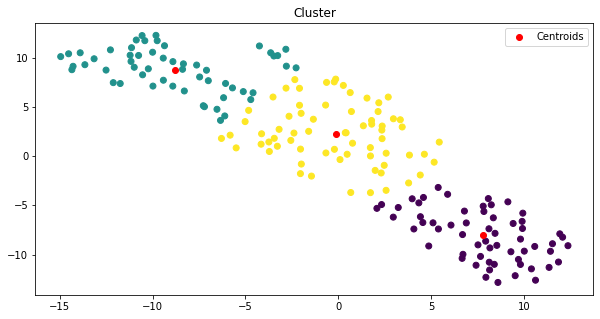

In [49]:
plot.figure(figsize=(10,5))

plot.scatter(X_reduzido[:, 0], X_reduzido[:, 1], s=plot.rcParams['lines.markersize']**2, c = kmeans.labels_)
plot.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],  c = 'red',label = 'Centroids')
plot.title('Cluster')
plot.legend()

plot.show()

In [50]:
cluster_list = kmeans.labels_
df_grouped["Cluster IDH"] = cluster_list

## Feature Engineering

In [51]:
paises = df_1.Paises.unique()

In [52]:
index_paises = []
for i in range(len(paises)):
    index_paises.append (df_1[df_1.Paises == paises[i]].index)

In [53]:
df_2 = pd.DataFrame()
for i in range(len(index_paises)):
    df_2 = pd.concat([df_2, df_1.iloc[index_paises[i]]], axis = 0)

In [54]:
df_2.reset_index(inplace=True)
df_2.drop('index', axis=1, inplace=True)

In [55]:
index_paises = []
for i in range(len(paises)):
    index_paises.append (df_2[df_2.Paises == paises[i]].index)

In [61]:
def feature_engineering (df, roll, paises, index_paises, drop):
    
    data = df.copy()
    
    roll += 1

    for i in range(len(paises)):
        #
        data.loc[index_paises[i],'Diff_1'] = data.iloc[index_paises[i]]['Expectativa de vida no nascimento']\
                                            .diff(roll - 1)
        data.loc[index_paises[i],'Diff_2'] = data.iloc[index_paises[i]]['Anos esperados de escolaridade']\
                                            .diff(roll - 1)
        data.loc[index_paises[i],'Diff_3'] = data.iloc[index_paises[i]]['Média de anos de escolaridade']\
                                            .diff(roll - 1)
        data.loc[index_paises[i],'Diff_4'] = data.iloc[index_paises[i]]['Renda nacional bruta (RNB) per capita (PPP US$)']\
                                            .diff(roll - 1)
        #
        data.loc[index_paises[i], 'Med_1'] = data.iloc[index_paises[i]]['Expectativa de vida no nascimento']\
                                            .rolling(roll).mean().round(2)
        data.loc[index_paises[i], 'Med_2'] = data.iloc[index_paises[i]]['Anos esperados de escolaridade']\
                                            .rolling(roll).mean().round(2)
        data.loc[index_paises[i], 'Med_3'] = data.iloc[index_paises[i]]['Média de anos de escolaridade']\
                                            .rolling(roll).mean().round(2)
        data.loc[index_paises[i], 'Med_4'] = data.iloc[index_paises[i]]['Renda nacional bruta (RNB) per capita (PPP US$)']\
                                            .rolling(roll).mean().round(2)
        #
        data.loc[index_paises[i], 'Var_%_1'] = data.iloc[index_paises[i]]['Expectativa de vida no nascimento']\
                                            .pct_change(roll - 1).round(horizonte)
        data.loc[index_paises[i], 'Var_%_2'] = data.iloc[index_paises[i]]['Anos esperados de escolaridade']\
                                            .pct_change(roll - 1).round(horizonte)
        data.loc[index_paises[i], 'Var_%_3'] = data.iloc[index_paises[i]]['Média de anos de escolaridade']\
                                            .pct_change(roll - 1).round(horizonte)
        data.loc[index_paises[i], 'Var_%_4'] = data.iloc[index_paises[i]]['Renda nacional bruta (RNB) per capita (PPP US$)']\
                                            .pct_change(roll - 1).round(horizonte)

    #if drop == True:
        #data.dropna(how='any', axis=0, inplace=True)
    
    return data

## Janelas de Previsão

In [78]:
roll = 1
janela = 2005 #fará o walk de janela + horizonte, nesse caso pegará do menor ano até 2005 conjunto de treino.
horizonte = 1 #quantos anos para frente tentará prever
passo = 1 #no loop soma esse valor a janela.
limite = df_2.Ano.unique().max() #quando o loop para.

In [79]:
df_3 = feature_engineering (df_2.drop('Faixa', axis=1), horizonte, paises, index_paises, True)

### Ajustar a partir daqui

In [75]:
colunas = df_3.select_dtypes(exclude=['int64', 'object']).columns.tolist()
    
for i in range (0, len(colunas)):
    df_3[colunas[i]] = df_3[colunas[i]].shift(periods=roll)

In [82]:
df_3[df_3.Ano == 1990]

,Paises,Ano,Expectativa de vida no nascimento,Anos esperados de escolaridade,Média de anos de escolaridade,Renda nacional bruta (RNB) per capita (PPP US$),Indice_Vida,Indice_Escola,Indice_Renda,Diff_1,...,Diff_3,Diff_4,Med_1,Med_2,Med_3,Med_4,Var_%_1,Var_%_2,Var_%_3,Var_%_4
0,Norway,1990,76.729,14.0,10.470000,17910.0,0.872754,0.737889,0.783669,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,Switzerland,1990,77.568,13.4,10.190000,28170.0,0.885662,0.711889,0.852082,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,Ireland,1990,74.809,12.1,9.730000,12750.0,0.843215,0.660444,0.732336,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,Germany,1990,75.488,14.4,8.770000,19640.0,0.853662,0.692333,0.797597,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120,China,1990,69.145,8.8,5.340000,17760.0,0.756077,0.422444,0.782398,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5370,Burundi,1990,47.829,4.4,1.440000,490.0,0.428138,0.170222,0.240063,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5400,South Sudan,1990,43.524,3.8,1.646667,575.0,0.361908,0.160444,0.264227,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5430,Chad,1990,47.019,3.2,1.853333,660.0,0.415677,0.150667,0.285053,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5460,Central African Republic,1990,49.104,5.2,2.060000,630.0,0.447754,0.213111,0.278026,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Regression Tree

In [27]:
def split_prev(df, ano_ref, ano_prev, pais):
    
    data = df.copy()
    
    treino =  data.loc[(data.Ano <= ano_ref) & (data.Paises == pais)].copy()
    teste = data.loc[(data.Ano > ano_ref) & (data.Ano <= ano_prev) & (data.Paises == pais)].copy()
    
    #não iremos utilizar essa coluna para treinar nosso modelo
    treino.drop(['Ano', 'Paises'], axis=1, inplace=True)
    teste.drop(['Ano', 'Paises'], axis=1, inplace=True)

    #vamos dividir as variáveis alvo e de entrada
    y_treino = treino['Expectativa de vida no nascimento'].values
    del treino['Expectativa de vida no nascimento']
    
    x_treino = treino.values

    y_teste = teste['Expectativa de vida no nascimento'].values
    del teste['Expectativa de vida no nascimento']

    x_teste = teste.values;
    
    #treino do modelo para fazer a previsão
    regr_1 = DecisionTreeRegressor(max_depth=5, min_samples_split = 2, random_state = 2019)
    regr_1.fit(x_treino, y_treino)
    
    y_pred_teste = regr_1.predict(x_teste)
    y_pred_treino = regr_1.predict(x_treino)
    
    # Avaliar o fitting
    rmse_teste = np.round(mean_squared_error(y_teste, y_pred_teste) **0.5, 2)
    rmse_treino = np.round(mean_squared_error(y_treino, y_pred_treino)**0.5, 2)
    
    return ano_ref, ano_prev, pais, rmse_teste, rmse_treino

In [28]:
def walk_forward (data, janela, horizonte, passo, limite):
    result = []
    pais_ref = data.Paises.unique()
    controle = limite - janela
    
    ano_ref = janela
    
    while controle >= 0:
        ano_prev = ano_ref + horizonte
        
        if ano_prev > limite:
            break
            return result
                
        for i in paises:
            result.append(split_prev(data, ano_ref, ano_prev, i))

        ano_ref += passo
        controle -= passo
    return result

In [29]:
def analise_estabilidade(data, janela, limite):
    result = []
    controle = limite - janela
    
    ano_ref = janela
    ano_prev = janela
    
    while controle >= 0:
        ano_prev += 1
        
        if ano_prev > limite:
            break
            return result
        
        for i in paises:
            result.append(split_prev(data, ano_ref, ano_prev, i))

        controle -= 1
    
    return result

In [31]:
df_walk_forward = pd.DataFrame(data = walk_forward (df_3, janela, horizonte, passo, limite),\
                          columns=['Ano_Ref','Ano_Prev','Pais','Rmse_teste','Rmse_treino'])

In [61]:
for i in range(len(df_walk_forward)):
    df_walk_forward['Periodo'][i] = str(df_walk_forward.Ano_Ref[i]) + ' - ' + str(df_walk_forward.Ano_Prev[i]);

In [67]:
df_walk_forward_agroup = df_walk_forward.groupby('Periodo').aggregate('mean')

In [77]:
df_walk_forward_agroup

,Ano_Ref,Ano_Prev,Rmse_teste,Rmse_treino
Periodo,,,,
2005 - 2006,2005,2006,0.482834,0.001444
2006 - 2007,2006,2007,0.641604,0.001711
2007 - 2008,2007,2008,0.610214,0.002193
2008 - 2009,2008,2009,0.737433,0.002834
2009 - 2010,2009,2010,0.699465,0.004225
2010 - 2011,2010,2011,0.658610,0.004813
2011 - 2012,2011,2012,0.590107,0.005508
2012 - 2013,2012,2013,0.647861,0.005187
2013 - 2014,2013,2014,0.607005,0.007540


Média do RSME:  0.6


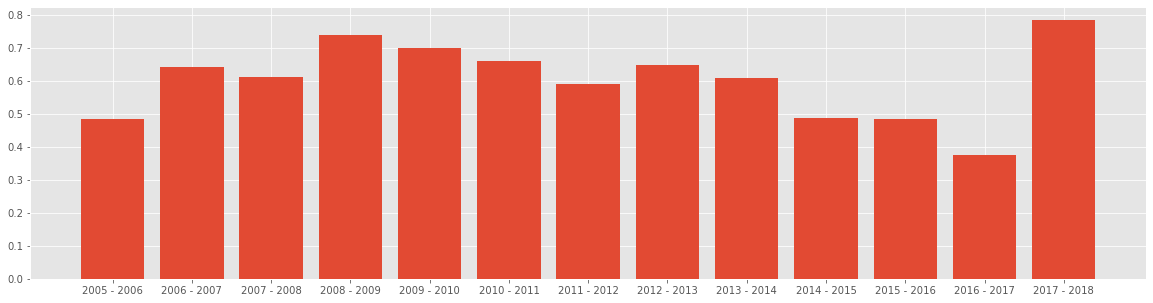

In [97]:
fig = plt.figure(figsize=(20,5))
plt.bar(df_walk_forward_agroup.index, df_walk_forward_agroup.Rmse_teste)
print ('Média do RSME: ', np.round(df_walk_forward_agroup.Rmse_teste.mean(),2))

In [82]:
df_estabilidade = pd.DataFrame(data =  analise_estabilidade(df_3, janela, limite),\
                               columns=['Ano_Ref','Ano_Prev', 'Pais','Rmse_teste','Rmse_treino'])

In [100]:
df_estabilidade.head()

,Ano_Ref,Ano_Prev,Pais,Rmse_teste,Rmse_treino
0,2005,2006,Norway,0.50,0.0
1,2005,2006,Switzerland,0.25,0.0
2,2005,2006,Ireland,0.35,0.0
3,2005,2006,Germany,0.21,0.0
4,2005,2006,China,0.29,0.0


In [101]:
for i in range(len(df_estabilidade)):
    df_estabilidade['Periodo'][i] = str(df_estabilidade.Ano_Ref[i]) + ' - ' + str(df_estabilidade.Ano_Prev[i]);

KeyError: 'Periodo'

In [ ]:
df_estabilidade_agroup = df_estabilidade.groupby('Periodo').aggregate('mean')